In [1]:
pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#visualizations
from sklearn import metrics
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/oral_cancer_prediction/data/oral_cancer_prediction_dataset.csv"
df = pd.read_csv(data_path)
df = df.set_index('ID')

In [ ]:
df.head()

Country  Age  ... Early Diagnosis Oral Cancer (Diagnosis)
ID                     ...                                        
1          Italy   36  ...              No                      No
2          Japan   64  ...              No                     Yes
3             UK   37  ...             Yes                     Yes
4      Sri Lanka   55  ...             Yes                      No
5   South Africa   68  ...              No                     Yes

[5 rows x 24 columns]

Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84922 entries, 1 to 84922
Data columns (total 24 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Country                                   84922 non-null  object 
 1   Age                                       84922 non-null  int64  
 2   Gender                                    84922 non-null  object 
 3   Tobacco Use                               84922 non-null  object 
 4   Alcohol Consumption                       84922 non-null  object 
 5   HPV Infection                             84922 non-null  object 
 6   Betel Quid Use                            84922 non-null  object 
 7   Chronic Sun Exposure                      84922 non-null  object 
 8   Poor Oral Hygiene                         84922 non-null  object 
 9   Diet (Fruits & Vegetables Intake)         84922 non-null  object 
 10  Family History of Cancer               

In [ ]:
df.shape

(84922, 24)

In [ ]:
df.isnull().sum()

Country                                     0
Age                                         0
Gender                                      0
Tobacco Use                                 0
Alcohol Consumption                         0
HPV Infection                               0
Betel Quid Use                              0
Chronic Sun Exposure                        0
Poor Oral Hygiene                           0
Diet (Fruits & Vegetables Intake)           0
Family History of Cancer                    0
Compromised Immune System                   0
Oral Lesions                                0
Unexplained Bleeding                        0
Difficulty Swallowing                       0
White or Red Patches in Mouth               0
Tumor Size (cm)                             0
Cancer Stage                                0
Treatment Type                              0
Survival Rate (5-Year, %)                   0
Cost of Treatment (USD)                     0
Economic Burden (Lost Workdays per Year)    0
Early Diagnosis                             0
Oral Cancer (Diagnosis)                     0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(1390)

In [ ]:
# check proportion of classes
df['Oral Cancer (Diagnosis)'].value_counts(normalize=True) * 100

Oral Cancer (Diagnosis)
No     50.131886
Yes    49.868114
Name: proportion, dtype: float64

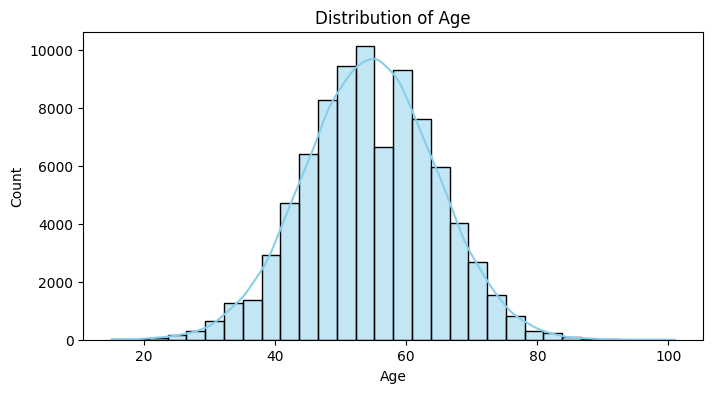

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df["Age"], bins=30, kde=True, color="skyblue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.show()

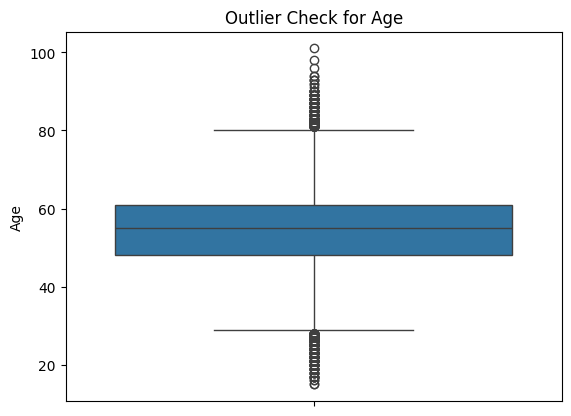

In [ ]:
sns.boxplot(data=df['Age'])
plt.title("Outlier Check for Age")
plt.show()


Text(0.5, 1.0, 'Risk Factors vs. Oral Cancer Diagnosis')

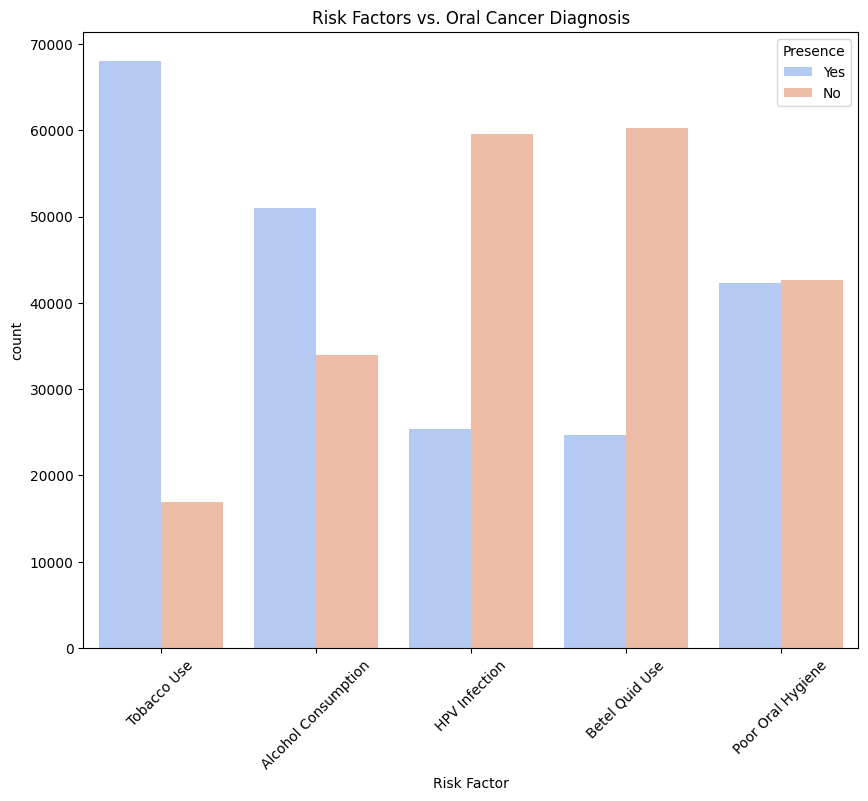

In [ ]:
plt.figure(figsize=(10, 8))
risk_factors = ["Tobacco Use", "Alcohol Consumption", "HPV Infection", "Betel Quid Use", "Poor Oral Hygiene"]
df_melted = df.melt(id_vars="Oral Cancer (Diagnosis)", value_vars=risk_factors, var_name="Risk Factor", value_name="Presence")
sns.countplot(data=df_melted, x="Risk Factor", hue="Presence", palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Risk Factors vs. Oral Cancer Diagnosis")

Feature Importance using tuned model

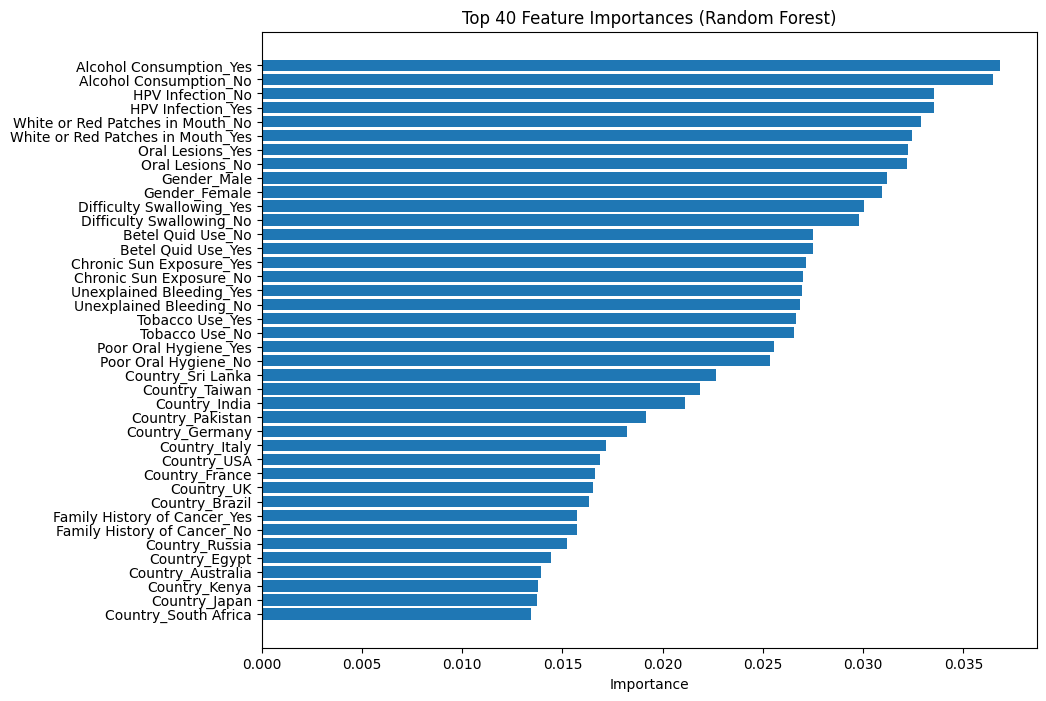

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load trained pipeline
rf_pipeline = joblib.load("/content/drive/MyDrive/oral_cancer_prediction/models/oral_cancer_rf.pkl")

# Get feature names after one-hot encoding
ohe = rf_pipeline.named_steps["preprocess"].named_transformers_["cat"]
encoded_features = ohe.get_feature_names_out(rf_pipeline.named_steps["preprocess"].transformers_[0][2])

# Get feature importances
importances = rf_pipeline.named_steps["model"].feature_importances_
feat_importances = pd.DataFrame({
    "Feature": encoded_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Top 40
feat_importances.head(40)

# Plot
plt.figure(figsize=(10,8))
plt.barh(feat_importances["Feature"].head(40), feat_importances["Importance"].head(40))
plt.gca().invert_yaxis()
plt.title("Top 40 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()


Feature Engineering

In [ ]:
df["Lifestyle_Risk_Score"] = (
    df["Tobacco Use"].map({"Yes": 1, "No": 0}) +
    df["Alcohol Consumption"].map({"Yes": 1, "No": 0}) +
    df["Betel Quid Use"].map({"Yes": 1, "No": 0}) +
    df["Chronic Sun Exposure"].map({"Yes": 1, "No": 0})
)

In [ ]:
symptom_cols = ["Oral Lesions", "Unexplained Bleeding", "Difficulty Swallowing", "White or Red Patches in Mouth"]
df["Symptom_Count"] = df[symptom_cols].apply(lambda x: (x == "Yes").sum(), axis=1)


In [ ]:
df["Country"].unique()

array(['Italy', 'Japan', 'UK', 'Sri Lanka', 'South Africa', 'Taiwan',
       'USA', 'Germany', 'France', 'Australia', 'Brazil', 'Pakistan',
       'Kenya', 'Russia', 'Nigeria', 'Egypt', 'India'], dtype=object)

In [ ]:
asia = ["India", "Sri Lanka", "Pakistan", "Taiwan","Japan"]
europe = ["Germany", "Italy", "UK", "France", "Russia"]
america = ["USA", "Brazil"]
africa = ["Egypt", "Kenya", "South Africa","Nigeria"]
oceania = ["Australia"]

def map_region(country):
    if country in asia: return "Asia"
    if country in europe: return "Europe"
    if country in america: return "America"
    if country in africa: return "Africa"
    if country in oceania: return "Oceania"
    return "Other"

df["Region"] = df["Country"].apply(map_region)
df = df.drop(columns=["Country"])


In [ ]:
df["Alcohol_Tobacco_Interaction"] = (
    df["Alcohol Consumption"].map({"Yes": 1, "No": 0}) *
    df["Tobacco Use"].map({"Yes": 1, "No": 0})
)


In [ ]:
df.head()

Age  Gender Tobacco Use Alcohol Consumption HPV Infection Betel Quid Use  \
ID                                                                             
1    36  Female         Yes                 Yes           Yes             No   
2    64    Male         Yes                 Yes           Yes             No   
3    37  Female          No                 Yes            No             No   
4    55    Male         Yes                 Yes            No            Yes   
5    68    Male          No                  No            No             No   

   Chronic Sun Exposure Poor Oral Hygiene Diet (Fruits & Vegetables Intake)  \
ID                                                                            
1                    No               Yes                               Low   
2                   Yes               Yes                              High   
3                   Yes               Yes                          Moderate   
4                    No               Yes                          Moderate   
5                    No               Yes                              High   

   Family History of Cancer  ... Treatment Type Survival Rate (5-Year, %)  \
ID                           ...                                            
1                        No  ...   No Treatment                100.000000   
2                        No  ...   No Treatment                 83.340103   
3                        No  ...        Surgery                 63.222871   
4                        No  ...   No Treatment                100.000000   
5                        No  ...   No Treatment                 44.293199   

   Cost of Treatment (USD) Economic Burden (Lost Workdays per Year)  \
ID                                                                    
1                     0.00                                        0   
2                 77772.50                                      177   
3                101164.50                                      130   
4                     0.00                                        0   
5                 45354.75                                       52   

   Early Diagnosis  Oral Cancer (Diagnosis)  Lifestyle_Risk_Score  \
ID                                                                  
1               No                       No                     2   
2               No                      Yes                     3   
3              Yes                      Yes                     2   
4              Yes                       No                     3   
5               No                      Yes                     0   

   Symptom_Count  Region  Alcohol_Tobacco_Interaction  
ID                                                     
1              0  Europe                            1  
2              1    Asia                            1  
3              1  Europe                            0  
4              1    Asia                            1  
5              0  Africa                            0  

[5 rows x 27 columns]

In [ ]:
df.to_csv("/content/drive/MyDrive/oral_cancer_prediction/data/f_engineered_dataset.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
df = pd.read_csv("/content/drive/MyDrive/oral_cancer_prediction/data/f_engineered_dataset.csv")


target_col = "Oral Cancer (Diagnosis)"
cat_cols = [
    "Gender", "Region", "Tobacco Use", "Alcohol Consumption",
    "HPV Infection", "Betel Quid Use", "Chronic Sun Exposure",
    "Poor Oral Hygiene", "Family History of Cancer",
    "Compromised Immune System", "Oral Lesions", "Unexplained Bleeding",
    "Difficulty Swallowing", "White or Red Patches in Mouth"
]
num_cols = ["Lifestyle_Risk_Score", "Symptom_Count", "Alcohol_Tobacco_Interaction"]

# --- 3️⃣ Prepare X and y ---
X = df[cat_cols + num_cols].copy()
y = df[target_col].copy()

# --- 4️⃣ Encode categorical variables temporarily ---
le = LabelEncoder()
X_encoded = X.copy()
for c in cat_cols:
    X_encoded[c] = le.fit_transform(X_encoded[c])

# Encode target
y_encoded = le.fit_transform(y)

# --- 5️⃣ Chi-square test ---
chi_scores, p_values = chi2(X_encoded, y_encoded)

chi_df = pd.DataFrame({
    "Feature": X_encoded.columns,
    "p_value": p_values
}).sort_values("p_value")

chi_df

Feature   p_value
9       Compromised Immune System  0.128560
7               Poor Oral Hygiene  0.313137
13  White or Red Patches in Mouth  0.603630
5                  Betel Quid Use  0.693001
8        Family History of Cancer  0.742029
3             Alcohol Consumption  0.767800
6            Chronic Sun Exposure  0.802297
2                     Tobacco Use  0.805112
10                   Oral Lesions  0.822960
1                          Region  0.848370
16    Alcohol_Tobacco_Interaction  0.863703
15                  Symptom_Count  0.878398
4                   HPV Infection  0.919978
14           Lifestyle_Risk_Score  0.945992
11           Unexplained Bleeding  0.950649
0                          Gender  0.953942
12          Difficulty Swallowing  0.994775